In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [2]:
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [3]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [4]:
# define a function for residual plot
def residual_plot(y_train, y_train_pred, y_test, y_test_pred):
  # Residual plot
  plt.scatter(
      y_train_pred,
      y_train_pred - y_train,
      c='blue',
      marker='o',
      label='Training data')
  plt.scatter(
      y_test_pred,
      y_test_pred - y_test,
      c='green',
      marker='s',
      label='Test data')

  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.legend(loc='upper left')
  xmin = min(y_train_pred.min(), y_test_pred.min())
  xmax = max(y_train_pred.max(), y_test_pred.max())
  plt.hlines(y=0, xmin=xmin, xmax=xmax, lw=2, color='red')
  plt.xlim([xmin, xmax])
  plt.tight_layout()
  plt.show()

In the following we use all features and RandomForestRegressor to train the dataset.

In [5]:
# select features, train model by yourself
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import itertools
X = X[['month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

print('Features:', X.columns.values)
print('[Linear]')
print('#Features: %d' % X_train.shape[1])

#Training data points: 1491
#Testing data points: 639
Features: ['month' 'day' 'hour' 'DEWP' 'TEMP' 'PRES' 'Iws']
[Linear]
#Features: 7


MSE train: 256.39, test: 1909.74
R^2 train: 0.98, test: 0.88


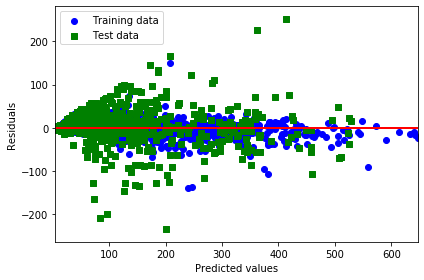

In [6]:
regr = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
regr = regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))
residual_plot(y_train, y_train_pred, y_test, y_test_pred)

In [7]:
class LinearRegressionGD(object):

  def __init__(self, eta=0.001, n_iter=20, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def predict(self, X):
    return self.net_input(X)

In [8]:
regr = LinearRegression()

print('[Linear]')
print('#Features: %d' % X_train.shape[1])
regr = regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('\n[Quadratic]')
quadratic = PolynomialFeatures(degree=2)
X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
print('#Features: %d' % X_quad_train.shape[1])
regr = regr.fit(X_quad_train, y_train)
y_train_pred = regr.predict(X_quad_train)
y_test_pred = regr.predict(X_quad_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('\n[Cubic]')
cubic = PolynomialFeatures(degree=3)
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)
print('#Features: %d' % X_cubic_train.shape[1])
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('\n[Penta]')
penta = PolynomialFeatures(degree=4)
X_cubic_train = penta.fit_transform(X_train)
X_cubic_test = penta.fit_transform(X_test)
print('#Features: %d' % X_cubic_train.shape[1])
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

[Linear]
#Features: 7
MSE train: 8481.80, test: 8970.38
R^2 train: 0.47, test: 0.42

[Quadratic]
#Features: 36
MSE train: 5817.64, test: 6379.44
R^2 train: 0.63, test: 0.59

[Cubic]
#Features: 120
MSE train: 4130.54, test: 4840.92
R^2 train: 0.74, test: 0.69

[Penta]
#Features: 330
MSE train: 2502.52, test: 3538.39
R^2 train: 0.84, test: 0.77
